# Analyze model

First: Create model similar to `exp_regression.ipynb`

In [1]:
# To make relative imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, COL_STUDENT, COL_STUDENT_PRED, COL_SALARY, COL_SALARY_PRED, FIG_DIR
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalary
import numpy as np
from statsmodels.tsa.api import VAR
import statsmodels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
courses = getAllCourses() # if you use all options, dont put that in the title down marked  there
courses = ['"Informatik"']
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)

SECTOR = ('WZ08-62', 'Dienstleistungen der Informationstechnologie')
inflationAdjasutedBruttoSalary = getInflationAdjustedBruttoSalary(SECTOR)
salaries = getSalaries()
SALARY_YEARS = salaries.index.levels[2]

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
4211.5 -> 4116.813294232649
4251.0 -> 4155.4252199413495
4302.5 -> 4091.2133763897286
4317.0 -> 4105.001312231135
4349.0 -> 4127.175509276376
4375.0 -> 4151.8493568829945
4428.0 -> 4156.425367195795
4491.5 -> 4216.030834859963
4538.0 -> 4155.784325100693
4593.0 -> 4206.151918287238
4584.0 -> 4107.54398091299
4598.0 -> 4120.0888360030385
4597.0 -> 4054.323597367301
4655.5 -> 4105.9176653346685
4805.0 -> 4204.136083692842
4854.0 -> 4247.008647293455
4927.5 -> 4281.348056300275
5012.5 -> 4355.20185331408
4930.0 -> 4266.4544091640255
4999.0 -> 4326.1674627608445
5064.0 -> 4309.163117071

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Test model accuracy
Delete last 2 timesteps and use them as a test set.

In [3]:
PAST_STEPS = 4
PREDICTION_STPES = 10

In [4]:
completeData = np.column_stack((totalStudents, inflationAdjasutedBruttoSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STPES])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'sallary', 'graduates'])

In [29]:
model = VAR(completeDataDF)

results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = trainData[-PAST_STEPS:]  # Use the last available values as lagged values
forecast, lower, upper = results.forecast_interval(lagged_values, steps=PREDICTION_STPES, alpha=0.05)
print(forecast)

[[ 1062.55249895  4337.94791681 52626.44722106]
 [ 1063.7313219   4351.59319146 52878.743036  ]
 [ 1103.81148863  4333.16926691 51756.11950564]
 [ 1129.4373178   4352.44990724 50605.17530378]
 [ 1162.81145127  4396.13444565 48545.9155866 ]
 [ 1173.27490878  4414.53977895 47066.2840107 ]
 [ 1196.93797288  4447.44849824 45792.78677958]
 [ 1205.51483787  4444.50914019 44619.40587533]
 [ 1226.4758437   4449.70137853 43142.58245807]
 [ 1232.88700477  4436.87580762 41684.54044918]]


/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
print("These are the absoulue diffrences between the predicted and the actual values")
np.set_printoptions(suppress=True)
absDiffernce = abs(forecast - testData)
print(absDiffernce)

print("\nThese are the percentage differences between the predicted and the actual values")
percentage_difference = (absDiffernce / testData) * 100
print(percentage_difference)

These are the absoulue diffrences between the predicted and the actual values
[[  31.44750105   28.78479974  531.44722106]
 [  29.7313219    33.49519825  783.743036  ]
 [  72.81148863   70.95067964  557.11950564]
 [  63.4373178    40.54440658  593.82469622]
 [ 146.81145127   14.35839675  599.0844134 ]
 [  80.27490878   47.83637015 2078.7159893 ]
 [  85.93797288   54.93747223  804.21322042]
 [  21.48516213   27.39020927 1977.59412467]
 [   6.4758437    57.47649095  942.41754193]
 [  17.11299523    8.20520646 2400.45955082]]

These are the percentage differences between the predicted and the actual values
[[ 2.87454306  0.66799049  1.02015015]
 [ 2.87536962  0.77569333  1.50444963]
 [ 7.06222004  1.66464197  1.08814529]
 [ 5.9509679   0.94028978  1.15983651]
 [14.44994599  0.32555085  1.21901397]
 [ 7.34445643  1.07199323  4.22976089]
 [ 7.73519108  1.25070767  1.72589055]
 [ 1.75103196  0.62009218  4.24403744]
 [ 0.53080686  1.30859627  2.13772835]
 [ 1.36903962  0.18459071  5.445071  ]

[ 974.46441936  959.35081445  979.48371034  984.04870944 1005.36630177
 1007.08647774 1023.5659811  1020.66224087 1030.32563424 1021.7839961 ] [ 964.46441936  949.35081445  969.48371034  974.04870944  995.36630177
  997.08647774 1013.5659811  1010.66224087 1020.32563424 1011.7839961 ]


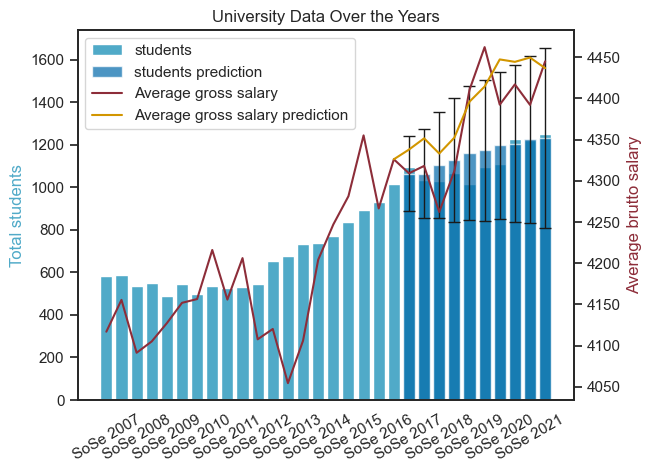

In [31]:
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)

print(lower[:, 0], lower[:, 0] - 10)

ax1.set_ylabel('Total students', color=COL_STUDENT)
ax1.bar(interestingYears[:-PREDICTION_STPES], trainData[:, 0], color=COL_STUDENT, label='students')
ax1.bar(interestingYears[-PREDICTION_STPES:], testData[:, 0], color=COL_STUDENT)
ax1.bar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], color=COL_STUDENT_PRED, alpha=0.7, label='students prediction')
ax1.errorbar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], yerr=upper[:, 0] - lower[:, 0], fmt='none', ecolor='k', elinewidth=1, capsize=4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
forecastWithPrevious = np.concatenate((trainData[-1, :].reshape(1, -1), forecast))

ax2.set_ylabel('Average brutto salary', color=COL_SALARY)
ax2.plot(interestingYears, completeData[:, 1], color=COL_SALARY, label='Average gross salary')
ax2.plot(interestingYears[-PREDICTION_STPES -1:], forecastWithPrevious[:, 1], color=COL_SALARY_PRED, label='Average gross salary prediction')


# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])
fig.savefig(FIG_DIR + f"/prediction_{PAST_STEPS}.pdf")
plt.show()

Documentation Link: [statsmodel](https://www.statsmodels.org/dev/vector_ar.html#statistical-tests)

In [32]:
with open('summary.txt', 'w') as file:
    file.write(str(results.summary()))

<Axes: >

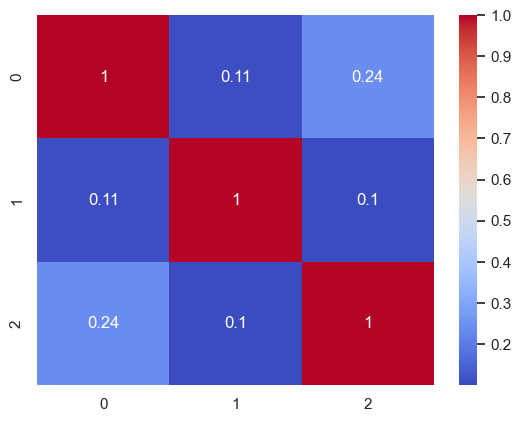

In [33]:
import seaborn as sns
resudiuals = results.resid
correlationMatrix = np.corrcoef(resudiuals, rowvar=False)
sns.set(style="white")
sns.heatmap(correlationMatrix, cmap="coolwarm", annot=True, )

In [34]:
point, lower, upper = results.forecast_interval(y=lagged_values, steps=PREDICTION_STPES, alpha=0.05)
print(point)
print(forecast)
print(lower)
print(upper)

[[ 1062.55249895  4337.94791681 52626.44722106]
 [ 1063.7313219   4351.59319146 52878.743036  ]
 [ 1103.81148863  4333.16926691 51756.11950564]
 [ 1129.4373178   4352.44990724 50605.17530378]
 [ 1162.81145127  4396.13444565 48545.9155866 ]
 [ 1173.27490878  4414.53977895 47066.2840107 ]
 [ 1196.93797288  4447.44849824 45792.78677958]
 [ 1205.51483787  4444.50914019 44619.40587533]
 [ 1226.4758437   4449.70137853 43142.58245807]
 [ 1232.88700477  4436.87580762 41684.54044918]]
[[ 1062.55249895  4337.94791681 52626.44722106]
 [ 1063.7313219   4351.59319146 52878.743036  ]
 [ 1103.81148863  4333.16926691 51756.11950564]
 [ 1129.4373178   4352.44990724 50605.17530378]
 [ 1162.81145127  4396.13444565 48545.9155866 ]
 [ 1173.27490878  4414.53977895 47066.2840107 ]
 [ 1196.93797288  4447.44849824 45792.78677958]
 [ 1205.51483787  4444.50914019 44619.40587533]
 [ 1226.4758437   4449.70137853 43142.58245807]
 [ 1232.88700477  4436.87580762 41684.54044918]]
[[  974.46441936  4250.63616313 48429.

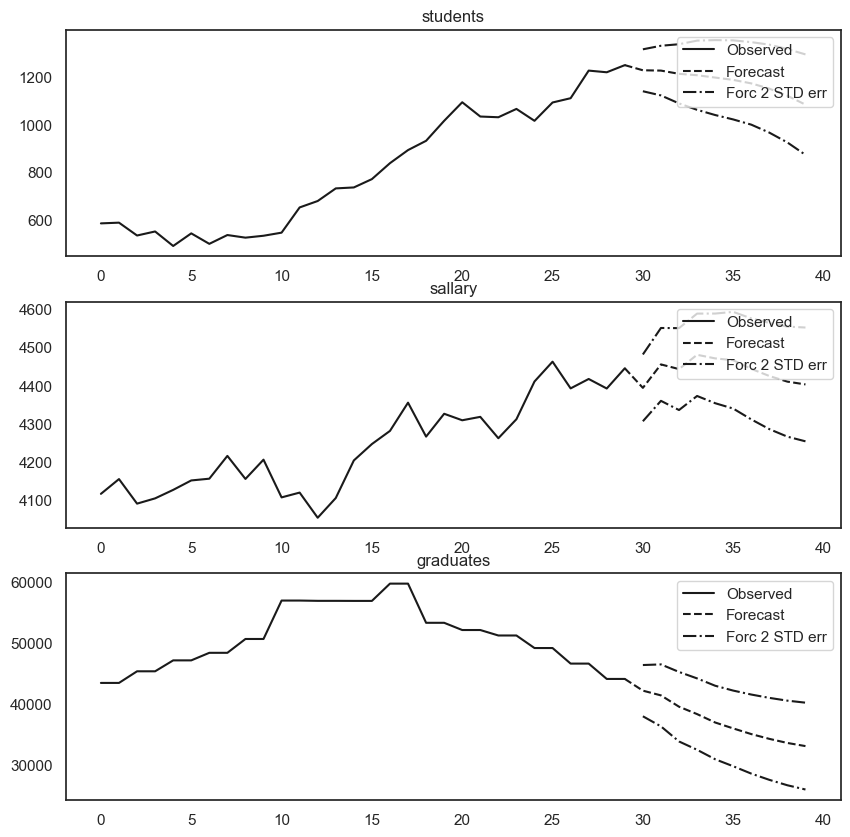

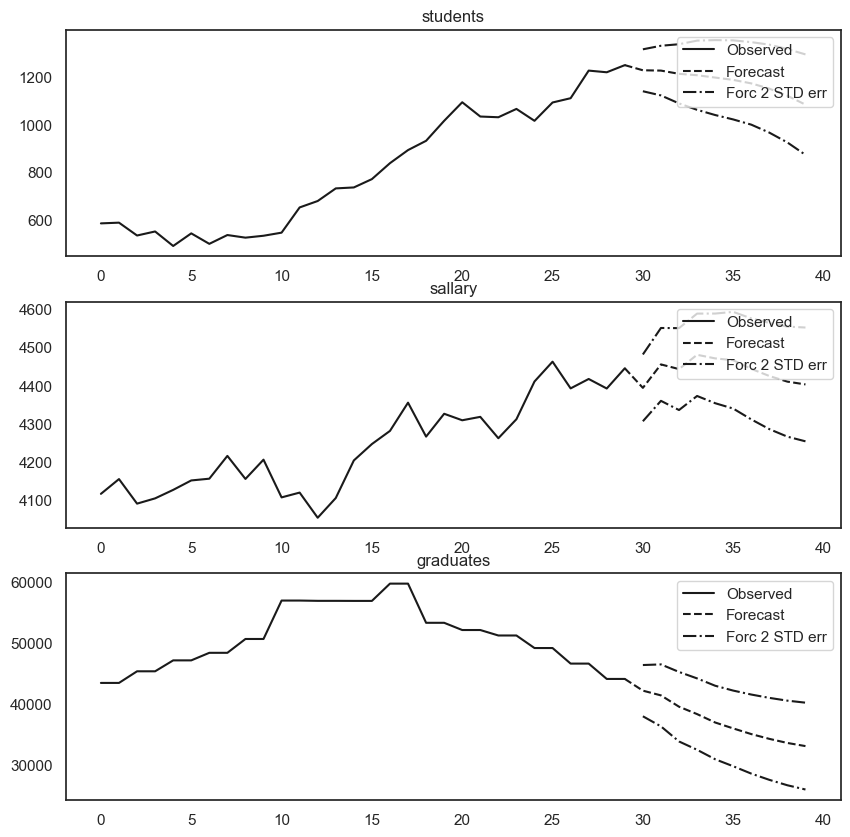

In [35]:
results.plot_forecast(10)


In [36]:
results.test_normality()